# Initial setting

## libraries

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [24]:
import re
import requests
import sys
from time import sleep
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools

from sklearn.utils import shuffle
from sklearn.utils import resample

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.inspection import permutation_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier

from sklearn.decomposition import PCA

from collections import OrderedDict

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [3]:
# create a progressbar function
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

## dataset

In [4]:
# Load data
df = pd.read_csv('data/df_fifa.csv')

To do
- select only European Division 1 leagues
- compare average overall scores of players by club

# Data handling

## create the dataset for Part C

In [45]:
# select players in the following clubs as test set
df_c = df[df['d_div1_league']==1]

# extract league and club
df_league_club = df_c.copy()
df_league_club = df_league_club[['league_name','club']].drop_duplicates()
df_league_club['variable'] = 'club_' + df_league_club['club']

# create lead variables for overall and value_eur (overall and value scores in the following year)
df_c = df_c.sort_values(['sofifa_id','year'])
df_c.insert(9,'overall_next',df_c.groupby(['sofifa_id'])['overall'].shift(-1))
df_c.insert(11,'value_eur_next',df_c.groupby(['sofifa_id'])['value_eur'].shift(-1))

# create dummies for club, nationality, 
df_c_dummies = pd.get_dummies(df_c[['nationality','club','work_rate']])
df_c = pd.concat([df_c, df_c_dummies], axis=1)

## drop columns, imputation, and train-test divide

In [6]:
df_c.to_csv('data/df_c.csv', index=False)

In [7]:
# drop unnecessary columns
drop_vars = ['sofifa_id','short_name','dob','nationality','club','wage_eur','preferred_foot','work_rate','body_type',
             'team_position','team_jersey_number','joined','contract_valid_until','league_name','release_clause_eur',
             'loaned_from','main_position','year']
df_c_all = df_c.drop(drop_vars, axis=1)

# impute zero values for fieldplayers and goalkeeping ability
# this is because goalkeeping ability is not available for field players and vice versa
impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic'] + [x for x in df_c_all.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_c_all[var] = df_c_all[var].fillna(0)
    
# impute mean value for ab_mentality_conposure
# Composure is a Player Attribute in FIFA that determines a player's the state or feeling of being calm and 
# controlling their frustration in matches frustration. (from FIFAplay)
df_c_all['ab_mentality_composure'].fillna(df_c_all['ab_mentality_composure'].mean(), inplace=True)

# save to csv
df_c_all.to_csv('data/df_c_all.csv', index=False)

In [8]:
# separate a dataset for overall score regression and drop NA
df_c_overall = df_c_all.copy().drop(['value_eur', 'value_eur_next'], axis=1)
df_c_overall = df_c_overall.dropna()
df_c_overall['diff_overall'] = df_c_overall['overall_next'] - df_c_overall['overall'] 

# save to csv
df_c_overall.to_csv('data/df_c_overall.csv', index=False)
df_c_overall.shape

(10517, 357)

# Regression

In [9]:
# assign X and y
X = df_c_overall.drop(['overall_next','overall','diff_overall'], axis=1)
y = df_c_overall['diff_overall']

In [10]:
# standardization
scaler = StandardScaler().fit(X)
X_stan = scaler.transform(X)

## LASSO

In [11]:
# set parameters
la_alphas = [1e-2, 1e-1, 1, 1e+1, 1e+2]

# create empty lists to store errors
tr_err, val_err = [],[]

# run regression for each alpha
for i,alpha in enumerate(la_alphas):
    # update progressbar
    progressbar(i, len(la_alphas))
    
    # perform cross-validation on the training data with 10 folds and get the mse_scores
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_validate(lasso, X_stan, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    
    #Compute the train and validation MSE
    tr_err.append(scores['train_score'].mean() * -1)
    val_err.append(scores['test_score'].mean() * -1)

# find the degree that returns the minimum validation error
min_val_err = min(val_err)
best_alpha = la_alphas[val_err.index(min_val_err)]
print(min_val_err, best_alpha)

 [==================================================] 5/5 Done...

6.748080239017591 0.01


In [12]:
# refit Lasso using best alpha
lasso_best = Lasso(alpha=best_alpha, max_iter=10000)
lasso_best.fit(X_stan, y)

# compute permutation importance
lasso_pi = permutation_importance(lasso_best, X_stan, y, scoring='neg_mean_squared_error', n_jobs=-1)

# turn the result into dataframe
df_lasso_pi = pd.DataFrame({'variable': X.columns, 'lasso': lasso_pi['importances_mean']})
df_lasso_pi = df_lasso_pi.sort_values(by='lasso',ascending=False)

In [13]:
df_lasso_pi.to_csv('data/df_lasso_pi.csv', index=False)

## Elastic Net

In [14]:
# parameters
en_alphas = np.logspace(-3, 3, 7)
en_l1ratios = np.arange(0.1, 1.0, 0.1)
 
en_params = {'alpha': en_alphas,
             'l1_ratio': en_l1ratios}
 
# grid search
en = ElasticNet(random_state=0, max_iter=10000)
en_gs = GridSearchCV(estimator=en,param_grid=en_params,scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)
en_gs.fit(X_stan, y)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:  8.9min finished


GridSearchCV(estimator=ElasticNet(max_iter=10000, random_state=0), n_jobs=-1,
             param_grid={'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             scoring='neg_mean_squared_error', verbose=1)

In [16]:
# extract best parameters and estimator
en_best_param = en_gs.best_params_
en_best_estimator = en_gs.best_estimator_

# compute permutation importance
en_pi = permutation_importance(en_best_estimator, X_stan, y, scoring='neg_mean_squared_error', n_jobs=-1)

# turn the result into dataframe
df_en_pi = pd.DataFrame({'variable': X.columns, 'elastic_net': en_pi['importances_mean']})
df_en_pi = df_en_pi.sort_values(by='elastic_net',ascending=False)

In [18]:
df_en_pi.to_csv('data/df_en_pi.csv', index=False)

## Random Forest (m=p/3)

In [19]:
# simple Random Forest regression
rf = RandomForestRegressor(max_depth=10, max_features=int(X_stan.shape[1]/3), random_state=0)
rf.fit(X_stan, y)

rf_tr_pred = rf.predict(X_stan)
rf_mse_tr = mean_squared_error(y, rf_tr_pred)
print(rf_mse_tr)

4.463669055221737


In [20]:
# parameters
rf_trees = list(range(150, 500, 50))
rf_depths = list(range(4, 10, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
clf = RandomForestRegressor(warm_start=True,max_features=int(X_stan.shape[1]/3),random_state=0)
clf_gs = GridSearchCV(estimator=clf,param_grid=rf_params,scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)
clf_gs.fit(X_stan, y)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 14.1min finished


GridSearchCV(estimator=RandomForestRegressor(max_features=118, random_state=0,
                                             warm_start=True),
             n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9],
                         'n_estimators': [150, 200, 250, 300, 350, 400, 450]},
             scoring='neg_mean_squared_error', verbose=1)

In [21]:
# extract best parameters and estimator
clf_best_param = clf_gs.best_params_
clf_best_estimator = clf_gs.best_estimator_

# compute permutation importance
rf_pi = permutation_importance(clf_best_estimator, X_stan, y, scoring='neg_mean_squared_error', n_jobs=-1)

# turn the result into dataframe
df_rf_pi = pd.DataFrame({'variable': X.columns, 'random_forest': rf_pi['importances_mean']})
df_rf_pi = df_rf_pi.sort_values(by='random_forest',ascending=False)

In [22]:
df_rf_pi.to_csv('data/df_rf_pi.csv', index=False)

# Visualization

In [25]:
# compile the list of dataframes to merge
# merge all dataframes
merge_dfs = [df_lasso_pi, df_en_pi, df_rf_pi]
df_pi = functools.reduce(lambda  left,right: pd.merge(left,right,on=['variable']), merge_dfs)
df_pi

,variable,lasso,elastic_net,random_forest
0,age,0.705445,0.611701,1.373173e+00
1,ab_movement_reactions,0.490214,0.453141,9.267627e-01
2,ab_skill_ball_control,0.351721,0.092524,2.406374e-01
3,d_pos_GK,0.343786,0.026946,8.385480e-07
4,ab_attacking_short_passing,0.249362,0.116767,1.314398e-01
...,...,...,...,...
349,nationality_Curacao,-0.000040,0.000037,0.000000e+00
350,nationality_Northern Ireland,-0.000049,0.000103,5.404835e-04
351,nationality_Austria,-0.000095,0.000182,7.595143e-04
352,club_RC Celta,-0.000122,0.000467,4.348474e-03


In [48]:
# merge all dataset
df_pi_club = df_pi.copy()
df_pi_club = df_pi_club.loc[df_pi_club['variable'].str.startswith('club')]

# rescale all feature importance
models = ['lasso', 'elastic_net', 'random_forest']
models_rescale = []
for model in models:
    df_pi_club[model + '_rescale'] = MinMaxScaler().fit_transform(df_pi_club[[model]])
    models_rescale.append(model + '_rescale')

# calculate mean of all scores 
df_pi_club['mean'] = df_pi_club[models_rescale].mean(axis=1) * 100

# merge league name
df_pi_club = df_pi_club.merge(df_league_club, on='variable')
df_pi_club = df_pi_club.sort_values(['league_name','mean'], ascending=False)
df_pi_club.to_csv('data/df_pi_club.csv', index=False)
df_pi_club

,variable,lasso,elastic_net,random_forest,lasso_rescale,elastic_net_rescale,random_forest_rescale,mean,league_name,club
1,club_Granada CF,0.028969,0.024427,0.002807,0.943408,0.908246,0.052418,63.469052,Spain Primera Division,Granada CF
3,club_CA Osasuna,0.018003,0.015728,0.003405,0.588794,0.584975,0.063962,41.257710,Spain Primera Division,CA Osasuna
9,club_Real Madrid,0.015589,0.014845,0.002090,0.510763,0.552171,0.038559,36.716405,Spain Primera Division,Real Madrid
10,club_RCD Espanyol,0.012973,0.011602,0.009620,0.426143,0.431626,0.184065,34.727800,Spain Primera Division,RCD Espanyol
25,club_Sevilla FC,0.005108,0.003815,0.006933,0.171843,0.142250,0.132138,14.874384,Spain Primera Division,Sevilla FC
...,...,...,...,...,...,...,...,...,...,...
92,club_Burnley,0.000000,0.000000,0.003178,0.006650,0.000468,0.059577,2.223198,English Premier League,Burnley
93,club_Everton,0.000000,0.000000,0.002795,0.006650,0.000468,0.052184,1.976772,English Premier League,Everton
86,club_Manchester United,0.000000,0.000000,0.002304,0.006650,0.000468,0.042704,1.660760,English Premier League,Manchester United
87,club_Liverpool,0.000000,0.000000,0.002138,0.006650,0.000468,0.039481,1.553322,English Premier League,Liverpool


<BarContainer object of 98 artists>

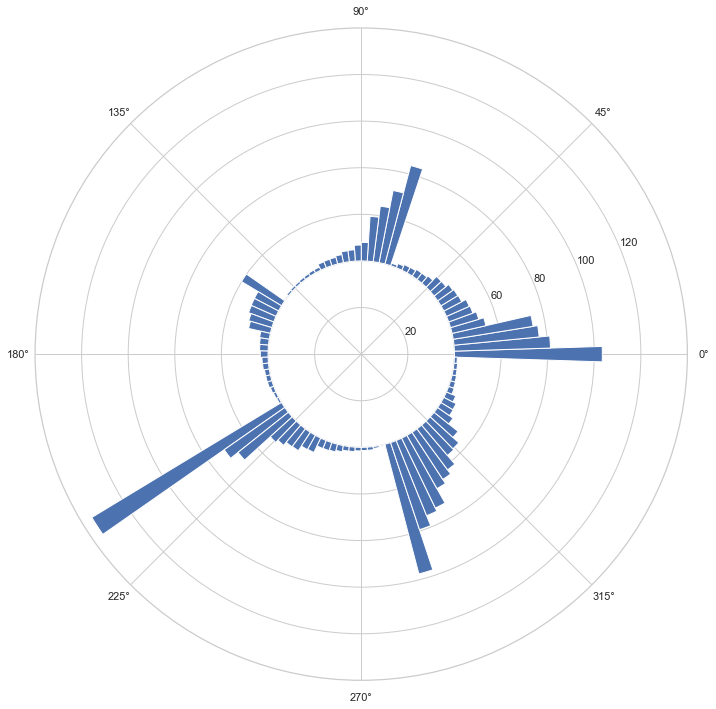

In [60]:
# create a circular bar plot
theta = np.linspace(0.0, 2 * np.pi, len(df_pi_club), endpoint=False)
width = (2*np.pi) / len(df_pi_club)
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection='polar'))
ax.bar(theta, df_pi_club['mean'], width=width, bottom=40)


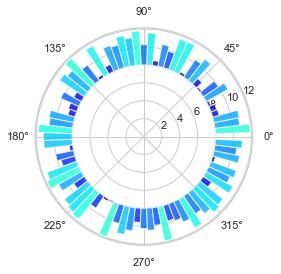

In [51]:
N = 80
bottom = 8
max_height = 4

theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = max_height*np.random.rand(N)
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)

plt.show()